<a href="https://colab.research.google.com/github/ayush3899/machine-learning-course-projects/blob/master/Copy_of_image_captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from tqdm import tqdm
import pandas as pd
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector, Concatenate, Activation, Flatten
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
import nltk

Using TensorFlow backend.


In [0]:
# https://yashk2810.github.io/Image-Captioning-using-InceptionV3-and-Beam-Search/
# https://towardsdatascience.com/image-captioning-with-keras-teaching-computers-to-describe-pictures-c88a46a311b8
    #for everything read above 

https://fairyonice.github.io/Develop_an_image_captioning_deep_learning_model_using_Flickr_8K_data.html

https://www.groundai.com/project/image-captioning/

https://towardsdatascience.com/image-captioning-with-keras-teaching-computers-to-describe-pictures-c88a46a311b8




In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!ls "/content/drive/My Drive/Flickr8k.zip"

'/content/drive/My Drive/Flickr8k.zip'


In [0]:
!unzip '/content/drive/My Drive/Flickr8k.zip'

Archive:  /content/drive/My Drive/Flickr8k.zip
   creating: Flickr8k_Dataset/
   creating: Flickr8k_Dataset/Flicker8k_Dataset/
  inflating: Flickr8k_Dataset/Flicker8k_Dataset/1003163366_44323f5815.jpg  
  inflating: Flickr8k_Dataset/Flicker8k_Dataset/1007320043_627395c3d8.jpg  
  inflating: Flickr8k_Dataset/Flicker8k_Dataset/1026685415_0431cbf574.jpg  
  inflating: Flickr8k_Dataset/Flicker8k_Dataset/103195344_5d2dc613a3.jpg  
  inflating: Flickr8k_Dataset/Flicker8k_Dataset/1056359656_662cee0814.jpg  
  inflating: Flickr8k_Dataset/Flicker8k_Dataset/107582366_d86f2d3347.jpg  
  inflating: Flickr8k_Dataset/Flicker8k_Dataset/1075867198_27ca2e7efe.jpg  
  inflating: Flickr8k_Dataset/Flicker8k_Dataset/1084040636_97d9633581.jpg  
  inflating: Flickr8k_Dataset/Flicker8k_Dataset/1088767354_2acee738cf.jpg  
  inflating: Flickr8k_Dataset/Flicker8k_Dataset/109202756_b97fcdc62c.jpg  
  inflating: Flickr8k_Dataset/Flicker8k_Dataset/1095580424_76f0aa8a3e.jpg  
  inflating: Flickr8k_Dataset/Flicker8k_

In [0]:
token = 'Flickr8k_text/Flickr8k.token.txt'

In [0]:
captions = open(token, 'r').read().strip().split('\n')

In [0]:
print(captions[0])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .


## Creating a dictionary containing all the captions of the images
Now, we create a dictionary named “descriptions” which contains the name of the image (without the .jpg extension) as keys and a list of the 5 captions for the corresponding image as values.

In [0]:
d = {}
for i, row in enumerate(captions):#to do counting the captions i is count and row is 
    row = row.split('\t') #split on tab split() method returns a list of strings
                       #after breaking the given string by the specified separator.
    row[0] = row[0][:len(row[0])-2] 
    if row[0] in d:
        d[row[0]].append(row[1])
    else:
        d[row[0]] = [row[1]]
        #basically what we are doing for every image put all it's captions

In [0]:
d['1000268201_693b08cb0e.jpg']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [0]:
images = 'Flickr8k_Dataset/Flicker8k_Dataset/'

In [0]:
# Contains all the images
img = glob.glob(images+'*.jpg')

# glob.glob(pathname)
# Return a possibly-empty list of path names that match pathname, which must be a string 
# containing a path specification. pathname can be either absolute 
# (like /usr/src/Python-1.5/Makefile) or relative (like ../../Tools/*/*.gif), and 
# can contain shell-style wildcards. Broken symlinks are included in the results

In [0]:
img[:5]

['Flickr8k_Dataset/Flicker8k_Dataset/498794783_cc2ac62b47.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/1164131282_b30926f332.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/3461437556_cc5e97f3ac.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/3370085095_6abbb67c1d.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/1489286545_8df476fa26.jpg']

In [0]:
train_images_file = 'Flickr8k_text/Flickr_8k.trainImages.txt'

In [0]:
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

In [0]:
def split_data(l):
    temp = []
    for i in img:
        if i[len(images):] in l:
            temp.append(i)
    return temp

In [0]:
# Getting the training images from all the images
train_img = split_data(train_images)
len(train_img)

6000

In [0]:
train_img[:5]

['Flickr8k_Dataset/Flicker8k_Dataset/498794783_cc2ac62b47.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/3461437556_cc5e97f3ac.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/3370085095_6abbb67c1d.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/1489286545_8df476fa26.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/3438858409_136345fa07.jpg']

In [0]:
val_images_file = 'Flickr8k_text/Flickr_8k.devImages.txt'
val_images = set(open(val_images_file, 'r').read().strip().split('\n'))

In [0]:
# Getting the validation images from all the images
val_img = split_data(val_images)
len(val_img)

1000

In [0]:
test_images_file = 'Flickr8k_text/Flickr_8k.testImages.txt'
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

In [0]:
# Getting the testing images from all the images
test_img = split_data(test_images)
len(test_img)

1000

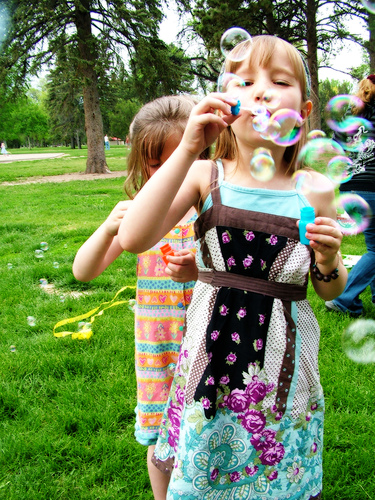

In [0]:
Image.open(train_img[0])

We will feed these images to VGG-16 to get the encoded images. Hence we need to preprocess the images as the authors of VGG-16 did. The last layer of VGG-16 is the softmax classifier(FC layer with 1000 hidden neurons) which returns the probability of a class. This layer should be removed so as to get a feature representation of an image. We will use the last Dense layer(4096 hidden neurons) after popping the classifier layer. Hence the shape of the encoded image will be (1, 4096)

# Data Preprocessing — Images
Images are nothing but input (X) to our model. As you may already know that any input to a model must be given in the form of a vector.

We need to convert every image into a fixed sized vector which can then be fed as input to the neural network. For this purpose, we opt for transfer learning by using the InceptionV3 model (Convolutional Neural Network) created by Google Research.

This model was trained on Imagenet dataset to perform image classification on 1000 different classes of images. However, our purpose here is not to classify the image but just get fixed-length informative vector for each image. This process is called automatic feature engineering.

Hence, we just remove the last softmax layer from the model and extract a 2048 length vector (bottleneck features) for every image as follows

https://cdn-images-1.medium.com/max/1200/1*9VoYufkvd-hBxK3p2NEWmw.png

In [0]:
def preprocess_input(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x

In [0]:
def preprocess(image_path):
  #Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    #Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    #dd one more dimension
    x = np.expand_dims(x, axis=0)
    #preprocess images using preprocess_input() from inception module x = preprocess_input(x) 
    #reshape from (1, 2048) to (2048, )
    x = preprocess_input(x)
    return x

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


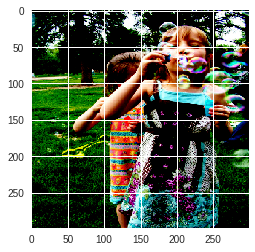

In [0]:
plt.imshow(np.squeeze(preprocess(train_img[0])))
# numpy.squeeze() function is used when we want to remove 
# single-dimensional entries from the shape of an array.

#InceptionV3
We need to convert every image into a fixed sized vector which can then be fed as input to the neural network. For this purpose, we opt for transfer learning by using the InceptionV3 model (Convolutional Neural Network) created by Google Research

In [0]:
model = InceptionV3(weights='imagenet')
# Get the InceptionV3 model trained on imagenet data

Instructions for updating:
Colocations handled automatically by placer.
96116736/96112376 [==============================] - 1s 0us/step


In [0]:
from keras.models import Model

new_input = model.input
hidden_layer = model.layers[-2].output ## Remove the last layer (output softmax layer) from the inception v3 

model_new = Model(new_input, hidden_layer)

In [0]:
tryi = model_new.predict(preprocess(train_img[0]))

In [0]:
print(tryi)

[[1.6616315  0.6619215  0.7821928  ... 1.2631544  0.817825   0.20280525]]


In [0]:
tryi.shape

(1, 2048)

In [0]:
tryi.shape[1]

2048

##Encoder and Decoder

An encoder is a network (FC, CNN, RNN, etc) that takes the input, and output a feature map/vector/tensor. These feature vector hold the information, the features, that represents the input. The decoder is again a network (usually the same network structure as encoder but in opposite orientation) that takes the feature vector from the encoder, and gives the best closest match to the actual input or intended output.

The encoders are trained with the decoders. There are no labels (hence unsupervised). The loss function is based on computing the delta between the actual and reconstructed input. The optimizer will try to train both encoder and decoder to lower this reconstruction loss.

Once trained, the encoder will gives feature vector for input that can be use by decoder to construct the input with the features that matter the most to make the reconstructed input recognizable as the actual input.

The same technique is being used in various different applications like in translation, generative models, etc.

It is important to know that in actual application, people donot try to reconstruct the actual input, but rather want to map/translate/associate inputs to certain outputs. For example translating french to english sentences, etc

In [0]:
def encode(image):
    image = preprocess(image)
    temp_enc = model_new.predict(image)
    temp_enc = np.reshape(temp_enc, temp_enc.shape[1])
    return temp_enc

In [0]:
# Remove the last layer (output softmax layer) from the inception v3
encoding_train = {}
for img in tqdm(train_img):#tqdm fo progress bars
    encoding_train[img[len(images):]] = encode(img)

100%|██████████| 6000/6000 [04:30<00:00, 22.16it/s]


##Pickle
Python pickle module is used for serializing and de-serializing a Python object structure. Any object in Python can be pickled so that it can be saved on disk. What pickle does is that it “serializes” the object first before writing it to file. Pickling is a way to convert a python object (list, dict, etc.) into a character stream. The idea is that this character stream contains all the information necessary to reconstruct the object in another python script.

##Python Pickle dump

 Use pickle.dump() function to store the object data to the file. pickle.dump() function takes 3 arguments. The first argument is the object that you want to store. The second argument is the file object you get by opening the desired file in write-binary (wb) mode. 

In [0]:
with open("encoded_images_inceptionV3.p", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle) 

#ImageNet
This model was trained on Imagenet dataset to perform image classification on 1000 different classes of images.

In [0]:
encoding_train = pickle.load(open('encoded_images_inceptionV3.p', 'rb'))

In [0]:
encoding_train['3556792157_d09d42bef7.jpg'].shape

(2048,)

In [0]:
encoding_test = {}
for img in tqdm(test_img):
    encoding_test[img[len(images):]] = encode(img)

100%|██████████| 1000/1000 [00:45<00:00, 22.13it/s]


In [0]:
with open("encoded_images_test_inceptionV3.p", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle) 

In [0]:
encoding_test = pickle.load(open('encoded_images_test_inceptionV3.p', 'rb'))

In [0]:
encoding_test[test_img[0][len(images):]].shape

(2048,)

In [0]:
train_d = {}
for i in train_img:
    if i[len(images):] in d:
        train_d[i] = d[i[len(images):]]

In [0]:
len(train_d)

6000

In [0]:
train_d[images+'3556792157_d09d42bef7.jpg']

['A bunch of children sitting in chairs and standing on wooden floors .',
 'A group of children sit , stand , and kneel along a wall .',
 'A group of children sitting on folding chairs and playing .',
 'a young group of children sitting in a row against the wall .',
 'The kids talking while sitting on a row of chairs along the wall .']

In [0]:
val_d = {}
for i in val_img:
    if i[len(images):] in d:
        val_d[i] = d[i[len(images):]]

In [0]:
len(val_d)

1000

In [0]:
test_d = {}
for i in test_img:
    if i[len(images):] in d:
        test_d[i] = d[i[len(images):]]

In [0]:
len(test_d)

1000

In [0]:
caps = []
for key, val in train_d.items():
    for i in val:
        caps.append('<start> ' + i + ' <end>')

In [0]:
words = [i.split() for i in caps]

In [0]:
print(words[0:10])

[['<start>', 'A', 'girl', 'in', 'a', 'dress', 'is', 'blowing', 'bubbles', 'with', 'another', 'girl', 'behind', 'her', '.', '<end>'], ['<start>', 'Girls', 'blow', 'bubbles', 'outdoors', '.', '<end>'], ['<start>', 'There', 'are', 'two', 'young', 'girls', 'in', 'colorful', 'dresses', 'blowing', 'bubbles', '.', '<end>'], ['<start>', 'Two', 'girls', 'in', 'colourful', 'dresses', 'blowing', 'bubbles', 'at', 'a', 'park', '.', '<end>'], ['<start>', 'Two', 'little', 'girls', 'wearing', 'bright', 'dresses', 'are', 'blowing', 'bubbles', 'with', 'bubble', 'wands', '.', '<end>'], ['<start>', 'Dogs', 'on', 'grass', '.', '<end>'], ['<start>', 'Three', 'dogs', 'are', 'running', 'on', 'the', 'grass', '.', '<end>'], ['<start>', 'Three', 'dogs', ',', 'one', 'white', 'and', 'two', 'brown', ',', 'are', 'running', 'together', 'on', 'a', 'field', 'of', 'grass', '.', '<end>'], ['<start>', 'Three', 'dogs', 'run', 'along', 'a', 'grassy', 'yard', '.', '<end>'], ['<start>', 'Three', 'dogs', 'run', 'together', 'in

In [0]:
unique = []
for i in words:
    unique.extend(i)

In [0]:
print(unique[0:50])

['<start>', 'A', 'girl', 'in', 'a', 'dress', 'is', 'blowing', 'bubbles', 'with', 'another', 'girl', 'behind', 'her', '.', '<end>', '<start>', 'Girls', 'blow', 'bubbles', 'outdoors', '.', '<end>', '<start>', 'There', 'are', 'two', 'young', 'girls', 'in', 'colorful', 'dresses', 'blowing', 'bubbles', '.', '<end>', '<start>', 'Two', 'girls', 'in', 'colourful', 'dresses', 'blowing', 'bubbles', 'at', 'a', 'park', '.', '<end>', '<start>']


In [0]:
unique = list(set(unique))

In [0]:
print(unique[0:50])

['attentive', 'high-flying', 'redhead', 'wagon', 'black-green', 'armor', 'messanger', 'picket', 'clever', 'outfir', 'needlepoint', 'Right', 'halter', 'o', 'monitors', 'american', 'Rafael', 'sloping', 'chases', 'safe', 'mountaineers', 'canopy', 'fires', 'handbags', 'Big', 'steering', 'meter', 'soars', 'Union', 'clowds', 'Distorted', 'huskey', 'boulder', '(', 'bites', 'saxophones', 'bottoms', 'corridor', 'goats', 'football', 'varied', 'Davison', 'looming', 'tread', 'skewed', 'equestrian', 'downwards', 'stains', 'tractor-like', 'dangerous']


In [0]:
unique = pickle.load(open('unique.p', 'rb'))

In [0]:
len(unique)

8256

# Data Preprocessing — Captions
We must note that captions are something that we want to predict. So during the training period, captions will be the target variables (Y) that the model is learning to predict.

But the prediction of the entire caption, given the image does not happen at once. We will predict the caption word by word. Thus, we need to encode each word into a fixed sized vector. However, this part will be seen later when we look at the model design, but for now we will create two Python Dictionaries namely “word2idx” (pronounced — word to index) and “idx2word” (pronounced — index to word).

Stating simply, we will represent every unique word in the vocabulary by an integer (index). As seen above, we have 8256 unique words in the corpus and thus each word will be represented by an integer index between 1 to 8256

These two Python dictionaries can be used as follows:

word2idx[‘abc’] -> returns index of the word ‘abc’

idx2word[k] -> returns the word whose index is ‘k’

The code used is as below:

In [0]:
word2idx = {val:index for index, val in enumerate(unique)}

In [0]:
word2idx['<start>']

5553

In [0]:
word2idx['<end>']

5232

In [0]:
# word2idx['a']

32

In [0]:
idx2word = {index:val for index, val in enumerate(unique)}

In [0]:
idx2word[5553]

'<start>'

In [0]:
idx2word[5232]

'<end>'

There is one more parameter that we need to calculate, i.e., the maximum length of a caption and we do it as below: which is 40

Since we would be doing batch processing (explained later), we need to make sure that each sequence is of equal length. Hence we need to append 0’s (zero padding) at the end of each sequence. But how many zeros should we append in each sequence?

Well, this is the reason we had calculated the maximum length of a caption, which is 40 (if you remember). So we will append those many number of zeros which will lead to every sequence having a length of 40.

In [0]:
max_len = 0
for c in caps:
    c = c.split()
    if len(c) > max_len:
        max_len = len(c)
max_len

40

In [0]:
len(unique), max_len

(8256, 40)

In [0]:
vocab_size = len(unique)

In [0]:
vocab_size

8256

In [0]:
f = open('flickr8k_training_dataset.txt', 'w')
f.write("image_id\tcaptions\n")

18

#Add token ''start'' and ''end'
 We will add two tokens in every caption as follows :

‘start’ -> This is a start sequence token which will be added at the start of every caption.

‘end’ -> This is an end sequence token which will be added at the end of every caption.

In [0]:
for key, val in train_d.items():
    for i in val:
        f.write(key[len(images):] + "\t" + "<start> " + i +" <end>" + "\n")

f.close()

In [0]:
df = pd.read_csv('flickr8k_training_dataset.txt', delimiter='\t')

In [0]:
len(df)

30000

In [0]:
c = [i for i in df['captions']]
len(c)

30000

In [0]:
imgs = [i for i in df['image_id']]

In [0]:
a = c[-1]
a, imgs[-1]

('<start> Young boys running along the pavement . <end>',
 '3724487641_d2096f10e5.jpg')

In [0]:
for i in a.split():
    print (i, "=>", word2idx[i])

<start> => 5553
Young => 3486
boys => 7050
running => 6030
along => 4438
the => 7392
pavement => 2465
. => 7023
<end> => 5232


In [0]:
samples_per_epoch = 0
for ca in caps:
    samples_per_epoch += len(ca.split())-1

In [0]:
samples_per_epoch

383454

In [0]:
steps_per_epoch=samples_per_epoch

##Generator
We will use the encoding of an image and use a start word to predict the next word. After that, we will again use the same image and use the predicted word to predict the next word. So, the image will be used at every iteration for the entire caption. This is how we will generate the caption for an image. Hence, we need to create a custom generator for that.

A generator function in Python is used exactly for this purpose. It’s like an iterator which resumes the functionality from the point it left the last time it was called.

The CS231n lecture by Andrej Karpathy explains this concept very clearly and beautifully. Link for the lecture:- https://youtu.be/cO0a0QYmFm8?t=32m25s

https://medium.freecodecamp.org/how-and-why-you-should-use-python-generators-f6fb56650888

In [0]:
def data_generator(batch_size = 32):
        partial_caps = []
        next_words = []
        images = []
        
        df = pd.read_csv('flickr8k_training_dataset.txt', delimiter='\t')
        df = df.sample(frac=1)
        iter = df.iterrows()
        c = []
        imgs = []
        for i in range(df.shape[0]):
            x = next(iter)
            c.append(x[1][1])
            imgs.append(x[1][0])


        count = 0
        while True:
            for j, text in enumerate(c):
                current_image = encoding_train[imgs[j]]
                for i in range(len(text.split())-1):
                    count+=1
                    
                    partial = [word2idx[txt] for txt in text.split()[:i+1]]
                    partial_caps.append(partial)
                    
                    # Initializing with zeros to create a one-hot encoding matrix
                    # This is what we have to predict
                    # Hence initializing it with vocab_size length
                    n = np.zeros(vocab_size)
                    # Setting the next word to 1 in the one-hot encoded matrix
                    n[word2idx[text.split()[i+1]]] = 1
                    next_words.append(n)
                    
                    images.append(current_image)

                    if count>=batch_size:
                        next_words = np.asarray(next_words)
                        images = np.asarray(images)
                        partial_caps = sequence.pad_sequences(partial_caps, maxlen=max_len, padding='post')
                        yield [[images, partial_caps], next_words]
                        partial_caps = []
                        next_words = []
                        images = []
                        count = 0

#Word Embedding  read this
https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/

How do you make a computer understand that “Apple” in “Apple is a tasty fruit” is a fruit that can be eaten and not a company?
And all of these are implemented by using Word Embeddings or numerical representations of texts so that computers may handle them.



In [0]:
embedding_size = 300

In [0]:
from keras.layers import Input, Dense,concatenate, Dropout
from keras.models import Model
from keras.layers.normalization import BatchNormalization

#Dense
A Dense layer feeds all outputs from the previous layer to all its neurons, each neuron providing one output to the next layer.

It's the most basic layer in neural networks.

A Dense(10) has ten neurons. A Dense(512) has 512 neurons

In [0]:
# image_model = Sequential()
# image_model.add(Dense(embedding_size , input_shape=(2048,), activation='relu'))
# image_model.add(RepeatVector(max_len))
# 

image_model_input=Input(shape=(2048,))
image_model_output=Dense(embedding_size,activation='relu')(image_model_input)
image_model_output=RepeatVector(max_len)(image_model_output)
#for repeat vector
#https://stackoverflow.com/questions/51749404/how-to-connect-lstm-layers-in-keras-repeatvector-or-return-sequence-true

In [0]:
from keras.utils import plot_model
# plot_model(image_model_output, to_file='image_model_img.png')

##TimeDistributed 
In keras - while building a sequential model - usually the second dimension (one after sample dimension) - is related to a time dimension. This means that if for example, your data is 5-dim with (sample, time, width, length, channel) you could apply a convolutional layer using TimeDistributed (which is applicable to 4-dim with (sample, width, length, channel)) along a time dimension (applying the same layer to each time slice) in order to obtain 5-d output.
Basically Ouput dimension==Input Dimension

https://datascience.stackexchange.com/questions/10836/the-difference-between-dense-and-timedistributeddense-of-keras

In [0]:
# caption_model = Sequential()
# caption_model.add(Embedding(vocab_size,embedding_size , input_length=max_len))
# caption_model.add(Bidirectional(LSTM(256,return_sequences=True)))
# # lang_model.add(Dropout(0.5))
# # lang_model.add(BatchNormalization())
# caption_model.add(TimeDistributed(Dense(300)))



caption_model_input=Input(shape=(40,))
caption_model_output=Embedding(vocab_size,embedding_size , input_length=max_len)(caption_model_input)
caption_model_output=Bidirectional(LSTM(256,return_sequences=True))(caption_model_output)
caption_model_output=Dropout(0.5)(caption_model_output)
caption_model_output=BatchNormalization()(caption_model_output)
caption_model_output=TimeDistributed(Dense(300))(caption_model_output)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
# from keras.utils import plot_model
# plot_model(caption_model_output, to_file='image_model_img.png')

#Model Architecture
Since the input consists of two parts, an image vector and a partial caption, we cannot use the Sequential API provided by the Keras library. For this reason, we use the Functional API which allows us to create Merge Models.

First, let’s look at the brief architecture which contains the high level sub-modules:


https://cdn-images-1.medium.com/max/1200/1*rfYN2EELhLvp2Van3Jo-Yw.jpeg

In [0]:
# final_model = Sequential()
# # fin_model.add(Merge([image_model, lang_model], mode='concat'))
# final_model.add(Concatenate([image_model, caption_model]))
# # final_model.add(Dropout(0.5))
# # final_model.add(BatchNormalization())
# final_model.add(Bidirectional(LSTM(256,return_sequences=False)))

# final_model.add(Dense(vocab_size))
# final_model.add(Activation('softmax'))
# print ("Model created!")

concat_layers = concatenate([image_model_output, caption_model_output])
concat_layers=Dropout(0.5)(concat_layers)
concat_layers=BatchNormalization()(concat_layers)
layer = Bidirectional(LSTM(256, return_sequences=False))(concat_layers)
layer = Dense(vocab_size)(layer)
outlayer = Activation('softmax')(layer)
final_model = Model([image_model_input, caption_model_input], [outlayer])
print('Model created!!')

Model created!!


In [0]:
# from keras.utils import plot_model
# plot_model(final_model)

In [0]:
final_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
# final_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [0]:
final_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 40, 300)      2476800     input_3[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 40, 512)      1140736     embedding_1[0][0]                
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
dropout_1 

In [0]:
# from keras.utils import plot_model
# plot_model(final_model, to_file='final_model_img.png')

#Training final_model visualization
https://keras.io/visualization/
refer this to visualize 

In [0]:
final_model.fit_generator(data_generator(batch_size=128),samples_per_epoch=samples_per_epoch/1000, nb_epoch=1, 
                          verbose=2)
# nb_val_samples with validation_steps
# samples_per_epoch=383454

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., verbose=2, steps_per_epoch=383.454, epochs=1)`
  


Epoch 1/1
 - 164s - loss: 4.9577 - acc: 0.2200


In [0]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch/1000, nb_epoch=1, 
                          verbose=2)

NameError: ignored

In [0]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch/500, nb_epoch=1, 
                          verbose=2)

NameError: ignored

In [0]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch/1000, nb_epoch=1, 
                          verbose=2)

Epoch 1/1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., verbose=2, steps_per_epoch=383.454, epochs=1)`
  


 - 157s - loss: 3.5123 - acc: 0.3603


In [0]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch/1000, nb_epoch=1, 
                          verbose=2)

Epoch 1/1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., verbose=2, steps_per_epoch=383.454, epochs=1)`
  


 - 157s - loss: 3.3831 - acc: 0.3648


In [0]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch/1000, nb_epoch=1, 
                          verbose=2)

Epoch 1/1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., verbose=2, steps_per_epoch=383.454, epochs=1)`
  


 - 156s - loss: 3.2477 - acc: 0.3789


In [0]:
final_model.optimizer.lr = 1e-4
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch/1000, nb_epoch=1, 
                          verbose=2)

Epoch 1/1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., verbose=2, steps_per_epoch=383.454, epochs=1)`
  This is separate from the ipykernel package so we can avoid doing imports until


 - 157s - loss: 3.2207 - acc: 0.3787


In [0]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch/1000, nb_epoch=1, 
                          verbose=2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., verbose=2, steps_per_epoch=383.454, epochs=1)`
  


Epoch 1/1
 - 157s - loss: 3.1258 - acc: 0.3909


In [0]:
final_model.save_weights('time_inceptionV3_7_loss_3.1258.h5')

In [0]:
final_model.load_weights('time_inceptionV3_7_loss_3.1258.h5')

In [0]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch/1000, nb_epoch=1, 
                          verbose=2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., verbose=2, steps_per_epoch=383.454, epochs=1)`
  


Epoch 1/1
 - 157s - loss: 3.0641 - acc: 0.3943


In [0]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch/1000, nb_epoch=1, 
                          verbose=2)

Epoch 1/1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., verbose=2, steps_per_epoch=383.454, epochs=1)`
  


 - 158s - loss: 3.0087 - acc: 0.3999


In [0]:
final_model.save_weights('time_inceptionV3_3.0087_loss.h5')

In [0]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch/1000, nb_epoch=1, 
                          verbose=2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., verbose=2, steps_per_epoch=383.454, epochs=1)`
  


Epoch 1/1
 - 158s - loss: 2.9526 - acc: 0.4030


In [0]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch/1000, nb_epoch=1, 
                          verbose=2)

Epoch 1/1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., verbose=2, steps_per_epoch=383.454, epochs=1)`
  


 - 158s - loss: 2.9106 - acc: 0.4067


In [0]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch/1000, nb_epoch=1, 
                          verbose=2)

Epoch 1/1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., verbose=2, steps_per_epoch=383.454, epochs=1)`
  


 - 158s - loss: 2.8876 - acc: 0.4084


In [0]:
final_model.save_weights('time_inceptionV3_2.8876_loss.h5')

In [0]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch/1000, nb_epoch=1, 
                          verbose=2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., verbose=2, steps_per_epoch=383.454, epochs=1)`
  


Epoch 1/1
 - 157s - loss: 2.8383 - acc: 0.4142


In [0]:
final_model.save_weights('time_inceptionV3_2.8383_loss.h5')

In [0]:
final_model.load_weights('time_inceptionV3_2.8383_loss.h5')

##Predict funtion

In [0]:
def predict_captions(image):
    start_word = ["<start>"]
    while True:
        par_caps = [word2idx[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        e = encoding_test[image[len(images):]]
        preds = final_model.predict([np.array([e]), np.array(par_caps)])
        word_pred = idx2word[np.argmax(preds[0])]
        start_word.append(word_pred)
        
        if word_pred == "<end>" or len(start_word) > max_len:
            break
            
    return ' '.join(start_word[1:-1])

In [0]:
def beam_search_predictions(image, beam_index = 3):
    start = [word2idx["<start>"]]
    
    start_word = [[start, 0.0]]
    
    while len(start_word[0][0]) < max_len:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_len, padding='post')
            e = encoding_test[image[len(images):]]
            preds = final_model.predict([np.array([e]), np.array(par_caps)])
            
            word_preds = np.argsort(preds[0])[-beam_index:]
            
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [idx2word[i] for i in start_word]

    final_caption = []
    
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption

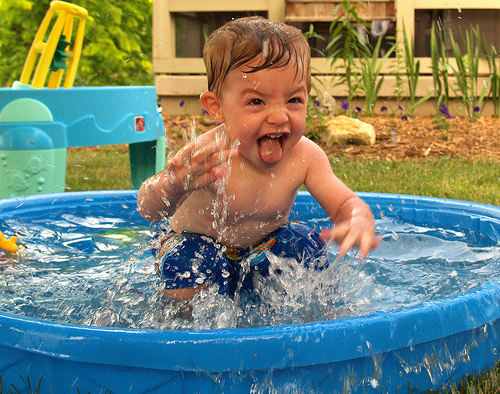

In [0]:
try_image = test_img[0]
Image.open(try_image)

In [0]:
print ('Normal Max search:', predict_captions(try_image)) 
print ('Beam Search, k=3:', beam_search_predictions(try_image, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(try_image, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(try_image, beam_index=7))

Normal Max search: A boy in a blue shirt is swimming in a pool .
Beam Search, k=3: A young boy in a swimming pool .
Beam Search, k=5: A boy in a swimming pool .
Beam Search, k=7: A boy in a swimming pool .


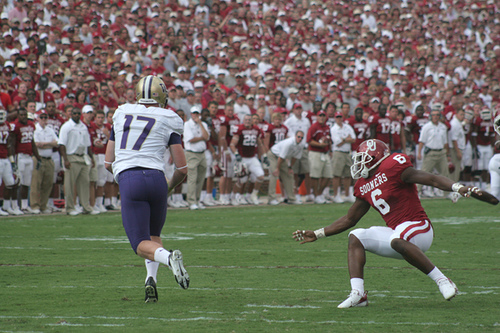

In [0]:
try_image2 = test_img[7]
Image.open(try_image2)

In [0]:
print ('Normal Max search:', predict_captions(try_image2)) 
print ('Beam Search, k=3:', beam_search_predictions(try_image2, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(try_image2, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(try_image2, beam_index=7))

Normal Max search: A football player in a red uniform is running in the field .
Beam Search, k=3: A football player in a red helmet is running in the field .
Beam Search, k=5: A football player tries to catch a soccer ball .
Beam Search, k=7: A football player tries to catch a soccer ball .


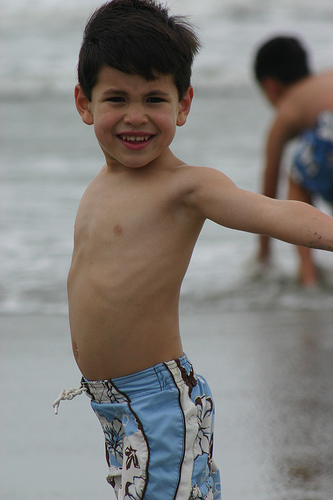

In [0]:
try_image3 = test_img[851]
Image.open(try_image3)

In [0]:
print ('Normal Max search:', predict_captions(try_image3)) 
print ('Beam Search, k=3:', beam_search_predictions(try_image3, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(try_image3, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(try_image3, beam_index=7))

Normal Max search: A boy in a bathing suit is holding a splash in the water .
Beam Search, k=3: A boy in a bathing suit is holding a splash in the water .
Beam Search, k=5: A young boy in a bathing suit is swimming in a swimming pool .
Beam Search, k=7: A boy in a bathing suit is swimming in a swimming pool .


Normal Max search: A man in a helmet is riding a bike in the woods .
Beam Search, k=3: A man in a red jacket is riding a dirt bike .
Beam Search, k=5: A man in a helmet is riding a dirt bike .
Beam Search, k=7: A bike rider riding a bike in the woods .


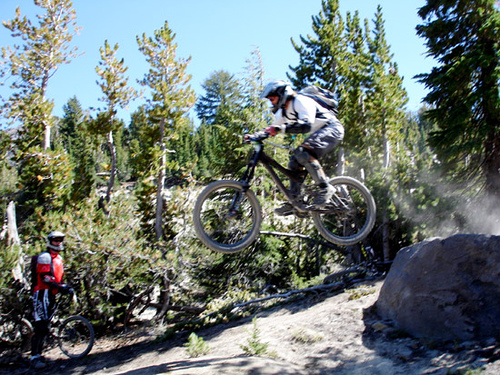

In [0]:
try_image4 = 'Flickr8k_Dataset/Flicker8k_Dataset/136552115_6dc3e7231c.jpg'
print ('Normal Max search:', predict_captions(try_image4))
print ('Beam Search, k=3:', beam_search_predictions(try_image4, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(try_image4, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(try_image4, beam_index=7))
Image.open(try_image4)

Normal Max search: A dog runs through the grass .
Beam Search, k=3: A black dog is running through the grass .
Beam Search, k=5: A black dog is running across the grass .
Beam Search, k=7: A black dog with a stick in its mouth .


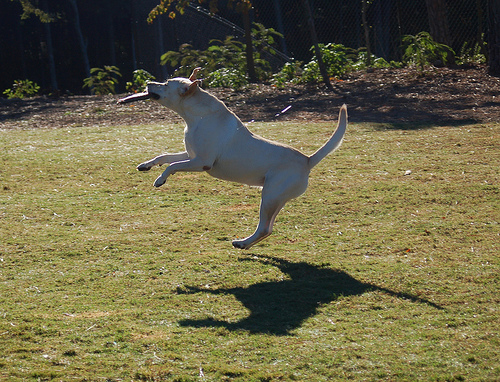

In [0]:
im = 'Flickr8k_Dataset/Flicker8k_Dataset/1674612291_7154c5ab61.jpg'
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)

Normal Max search: A dog runs through the snow .
Beam Search, k=3: A dog is running through the snow .
Beam Search, k=5: The dog is running through the snow .
Beam Search, k=7: The dog is running through the snow .


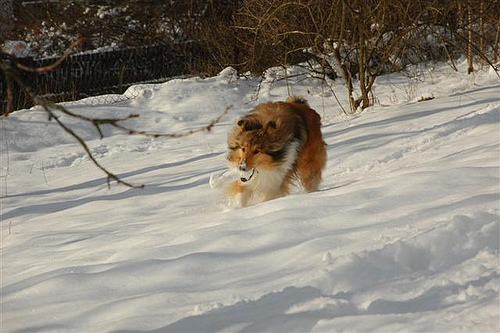

In [0]:
im = 'Flickr8k_Dataset/Flicker8k_Dataset/384577800_fc325af410.jpg'
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)

Normal Max search: A man is surfing in the air .
Beam Search, k=3: A group of people on a wave .
Beam Search, k=5: A man riding a wave .
Beam Search, k=7: A man riding a wave .


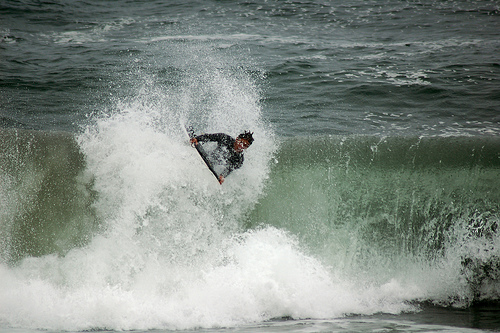

In [0]:
im = 'Flickr8k_Dataset/Flicker8k_Dataset/3631986552_944ea208fc.jpg'
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)

Normal Max search: A child in a red jacket is jumping through the snow .
Beam Search, k=3: A child in a red jacket is wearing a red jacket .
Beam Search, k=5: A child in the snow .
Beam Search, k=7: A child in the snow .


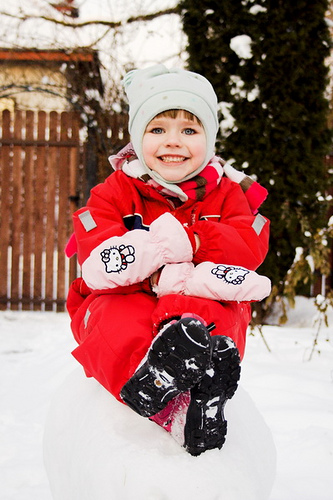

In [0]:
im = 'Flickr8k_Dataset/Flicker8k_Dataset/3320032226_63390d74a6.jpg'
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)

Normal Max search: A man in a helmet is riding a bike .
Beam Search, k=3: A man in a helmet is riding a bike .
Beam Search, k=5: A man in a helmet is riding a dirt bike .
Beam Search, k=7: A bike rider riding a dirt bike .


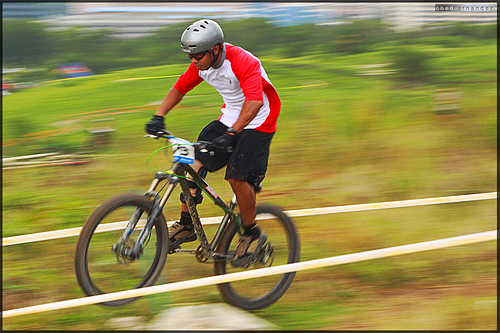

In [0]:
im = 'Flickr8k_Dataset/Flicker8k_Dataset/3316725440_9ccd9b5417.jpg'
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)

Normal Max search: A man is doing a trick on a skateboard .
Beam Search, k=3: A man does a trick on a skateboard .
Beam Search, k=5: A man does a trick on a skateboard .
Beam Search, k=7: A man does a trick on a skateboard .


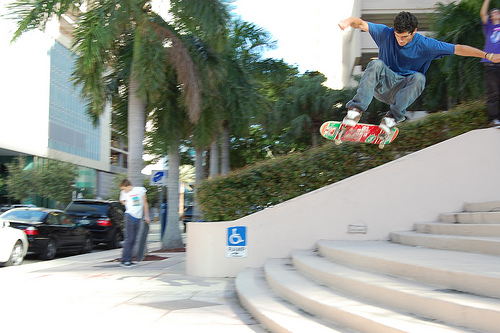

In [0]:
im = 'Flickr8k_Dataset/Flicker8k_Dataset/2306674172_dc07c7f847.jpg'
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)

Normal Max search: A dog is running through a field of leaves .
Beam Search, k=3: A brown dog is jumping over a hurdle .
Beam Search, k=5: A brown dog with a toy in its mouth .
Beam Search, k=7: A brown dog with a Frisbee in its mouth .


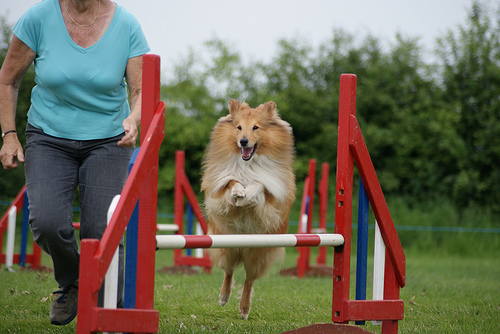

In [0]:
im = 'Flickr8k_Dataset/Flicker8k_Dataset/2542662402_d781dd7f7c.jpg'
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)

Flickr8k_Dataset/Flicker8k_Dataset/3595643050_d312e4b652.jpg
Normal Max search: A dog is running through the air to catch a ball .
Beam Search, k=3: A brown dog is jumping over a hurdle .
Beam Search, k=5: A brown dog and a white dog are running through the grass .
Beam Search, k=7: A brown dog and a white dog are running through the grass .


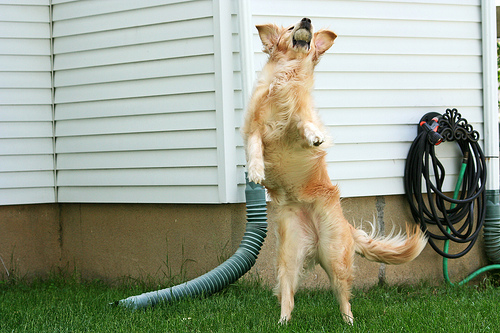

In [0]:
im = test_img[int(np.random.randint(0, 1000, size=1))]
print (im)
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)

In [0]:
# !ls 'nic.jpg'
# Image.open('nice.png')

In [0]:
# def predict_captions(image):
#     start_word = ["<start>"]
#     while True:
#         par_caps = [word2idx[i] for i in start_word]
#         par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
#         e = encoding_test[image[len(images):]]
#         preds = final_model.predict([np.array([e]), np.array(par_caps)])
#         word_pred = idx2word[np.argmax(preds[0])]
#         start_word.append(word_pred)
        
#         if word_pred == "<end>" or len(start_word) > max_len:
#             break
            
#     return ' '.join(start_word[1:-1])

In [0]:
im = 'Flickr8k_Dataset/Flicker8k_Dataset/255266148_7ba7df1a88.jpg'
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)

KeyError: ignored